# Alzheimer's Prediction (Multi-Class) 
* See [Alzheimer's Prediction](https://github.com/grantgasser/Alzheimers-Prediction) for more detail

# Note: This notebook is being refactored
* More EDA
* Proper train/test split 
* Use `AUC` as main metric for evaluation, NOT accuracy

In [1]:
import numpy as np
import sklearn as sk
import pandas as pd
import os

In [3]:
#Read data
dat = pd.read_csv('AD_Challenge_Training_Data_Clinical_Updated_7.22.2014/ADNI_Training_Q3_APOE_CollectionADNI1Complete 1Yr 1.5T_July22.2014.csv')

#Check NA values, 1 NA for imputed_genotype
# dat.isnull().sum()

### Remove NA

In [5]:
dat = dat.dropna()
dat.isnull().sum().sum()

0

In [6]:
#Peek at data
dat.head(3)

,directory.id,Subject,RID,Image.Data.ID,Modality,Visit,Acq.Date,DX.bl,EXAMDATE,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,APOE4,MMSE,imputed_genotype,APOE Genotype,Dx Codes for Submission
0,4702245ea294ce5d4e9b8a87027dfdf4,011_S_0003,3,32237,MRI,1,9/1/2005,AD,9/12/2005,81.3,Male,18,Not Hisp/Latino,White,1,20,True,"3,4",AD
1,2e89e352af743597b2368c412e0f6de2,022_S_0004,4,64631,MRI,1,9/22/2005,LMCI,11/8/2005,67.5,Male,10,Hisp/Latino,White,0,27,False,"3,3",MCI
2,90419199306997753de8042f1fd55e38,011_S_0005,5,32246,MRI,1,9/2/2005,CN,9/7/2005,73.7,Male,16,Not Hisp/Latino,White,0,29,True,"3,3",CN


### Remove ID's and other features

In [7]:
X = dat
Y = dat['DX.bl']
del dat

#Remove unnecessary columns (features), remove first 9 columns and 'Dx codes for submission'
remove_columns = list(X.columns)[0:9]
remove_columns.append('Dx Codes for Submission')
print('Removing columns:', remove_columns)

X = X.drop(remove_columns, axis=1)

features = list(X.columns)
X.head(5)

Removing columns: ['directory.id', 'Subject', 'RID', 'Image.Data.ID', 'Modality', 'Visit', 'Acq.Date', 'DX.bl', 'EXAMDATE', 'Dx Codes for Submission']


,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,APOE4,MMSE,imputed_genotype,APOE Genotype
0,81.3,Male,18,Not Hisp/Latino,White,1,20,True,"3,4"
1,67.5,Male,10,Hisp/Latino,White,0,27,False,"3,3"
2,73.7,Male,16,Not Hisp/Latino,White,0,29,True,"3,3"
3,80.4,Female,13,Not Hisp/Latino,White,0,25,True,"3,3"
4,73.9,Female,12,Not Hisp/Latino,White,1,24,True,"3,4"


## Exploratory Data Analysis (EDA)

In [11]:
numerical_vars = ['AGE', 'MMSE', 'PTEDUCAT']
cat_vars = list(set(features) - set(numerical_vars))

print('Categorical variable distributions:\n')

for var in cat_vars:
    print('\nDistribution of', var)
    
    print(X[var].value_counts())

Categorical variable distributions:


Distribution of PTETHCAT
Not Hisp/Latino    616
Hisp/Latino          8
Unknown              3
Name: PTETHCAT, dtype: int64

Distribution of PTRACCAT
White    583
Black     31
Asian     13
Name: PTRACCAT, dtype: int64

Distribution of APOE Genotype
3,3    275
3,4    221
4,4     71
2,3     45
2,4     13
2,2      2
Name: APOE Genotype, dtype: int64

Distribution of APOE4
0    322
1    234
2     71
Name: APOE4, dtype: int64

Distribution of imputed_genotype
True     466
False    161
Name: imputed_genotype, dtype: int64

Distribution of PTGENDER
Male      363
Female    264
Name: PTGENDER, dtype: int64


#### Categorical Var Distribution Notes
* Ethnicity and Race are separate vars
* Distribution of Hispanic, Black, White, Asian not quite same as overall American ethnic/racial distribution
* APOE Genotype with 3 in the first spot seems to be overwhelming majority `3,3` and `3,4`
* More males than females for some reason

Numerical Var Distributions:



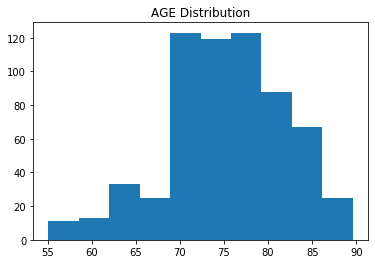

count    627.000000
mean      75.161882
std        6.689979
min       55.100000
25%       71.200000
50%       75.400000
75%       80.000000
max       89.600000
Name: AGE, dtype: float64


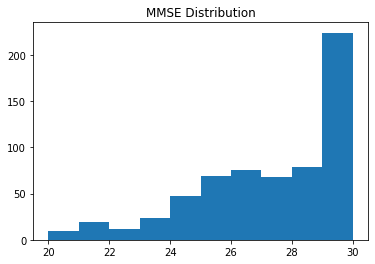

count    627.000000
mean      26.921850
std        2.563934
min       20.000000
25%       25.000000
50%       27.000000
75%       29.000000
max       30.000000
Name: MMSE, dtype: float64


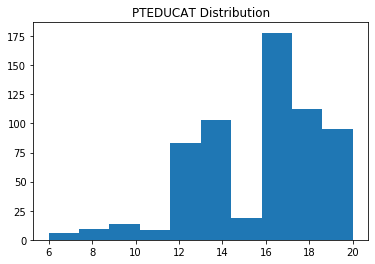

count    627.000000
mean      15.612440
std        2.978845
min        6.000000
25%       13.000000
50%       16.000000
75%       18.000000
max       20.000000
Name: PTEDUCAT, dtype: float64


In [28]:
from matplotlib import pyplot as plt
%matplotlib inline

print('Numerical Var Distributions:\n')

for var in numerical_vars:
    plt.hist(X[var])
    plt.title(var + ' Distribution')
    plt.show()
    
    # descriptive stats
    print(X[var].describe())

### Analyze target (y) distribution
* High number (304) of limited impairment (LMCI). Maybe old age? Or the patients being evaluated are not random elderly patients but patients already known to have cognitive issues

<BarContainer object of 3 artists>

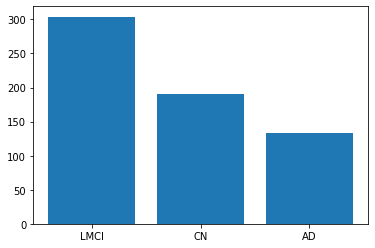

In [38]:
plt.bar(Y.value_counts().index, Y.value_counts())

## Pre-processing

### Convert Categorical Variables to 1-Hot
* Next time use `sklearn.preprocessing.OneHotEncoder`

In [39]:
#for each categorical var, convert to 1-hot encoding
for var in cat_vars:
    print('Converting', var, 'to 1-hot encoding')
    
    #get 1-hot and replace original column with the >= 2 categories as columns
    one_hot_df = pd.get_dummies(X[var])
    X = pd.concat([X, one_hot_df], axis=1)
    X = X.drop(var, axis=1)
    
X.head(4)

Converting PTETHCAT to 1-hot encoding
Converting PTRACCAT to 1-hot encoding
Converting APOE Genotype to 1-hot encoding
Converting APOE4 to 1-hot encoding
Converting imputed_genotype to 1-hot encoding
Converting PTGENDER to 1-hot encoding


,AGE,PTEDUCAT,MMSE,Hisp/Latino,Not Hisp/Latino,Unknown,Asian,Black,White,"2,2",...,"3,3","3,4","4,4",0,1,2,False,True,Female,Male
0,81.3,18,20,0,1,0,0,0,1,0,...,0,1,0,0,1,0,0,1,0,1
1,67.5,10,27,1,0,0,0,0,1,0,...,1,0,0,1,0,0,1,0,0,1
2,73.7,16,29,0,1,0,0,0,1,0,...,1,0,0,1,0,0,0,1,0,1
3,80.4,13,25,0,1,0,0,0,1,0,...,1,0,0,1,0,0,0,1,1,0


### Remember:
* PTGENDER: (Male, Female)
* PTETHCAT: (Hisp/Latino, Not Hisp/Latino, Unknown)
* PTRACCAT: (White, Black, Asian)
* APOE4: (1, 0)
* APOE4 Genotype: (22, 23, 24, 33, 34, 44)
* imputed_genotype (True, False)

### Normalization code if necessary
* Could also use from `sklearn.preprocessing` `StandardScaler` or `Normalizer` or `MinMaxScaler`

In [40]:
def normalize(X):
    """
    Normalize numerical variables for faster and better convergence
    
    Args:
        X (pd.DataFrame): data
        
    Returns:
        X (numpy array): same data but with normalized numerical features
    """

    #Convert to numpy array
    X = np.array(X)
    sanity_check = 0

    #Normalize numerical variables to speed up convergence
    for i in range(3):
        mean = np.mean(X[:, i])
        sd = np.std(X[:, i])
        print('\nNormalizing', numerical_vars[i], 'with mean=', format(mean, '.2f'), 'and sd=', format(sd, '.2f'))

        X[:, i] = (X[:, i] - mean) / sd
        sanity_check += np.mean(X[:, i])

    print('\nSanity Check. Sum of all the means should be near 0:', sanity_check)

    return X

# TODO:
* pick up back here
* 627 examples enough to do hyperparameter tuning? Probably not
* start with random forest to get feature importance

## SVM Classifier
* See [here](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC) for more details

In [9]:
from sklearn.svm import LinearSVC

### SVM Setup
* SVM uses Hinge Loss
* Hinge Loss: $l_h = max(0, 1 - y * \mathbf{w^Tx}$)
* Regularization: $\lambda||\mathbf{w}||_2^2$

In [10]:
#Train classifier
clf_svm = LinearSVC(penalty='l2', loss='hinge', multi_class='ovr', max_iter = 100000)  #ovr: 'One v. Rest/All'
clf_svm.fit(X_train, Y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=100000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0)

In [11]:
#Make predictions on test data
clf_svm_predictions = clf_svm.predict(X_test)
svm_accuracy = (clf_svm_predictions == Y_test)

In [12]:
#Evaluate accuracy
print('Test Accuracy: ', format(np.sum(svm_accuracy)/m_test, '.2%'))

Test Accuracy:  56.05%


### Decision Tree

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate, cross_val_score, cross_val_predict

In [14]:
#Decision Tree with 5-fold CV
clf_tree = DecisionTreeClassifier()
scores = cross_val_score(clf_tree, X_train, Y_train, cv=5)
scores

array([0.62105263, 0.66315789, 0.70526316, 0.53763441, 0.61290323])

In [15]:
print('95% CI: Mean score', format(scores.mean(), '.2%'), '+/-', format(scores.std()*2, '.2%'))

95% CI: Mean score 62.80% +/- 11.19%


In [16]:
#Expect a result in this interval
clf_tree.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [17]:
clf_tree_predictions = clf_tree.predict(X_test)

In [18]:
tree_accuracy = (clf_tree_predictions == Y_test)
#Evaluate accuracy
print('Test Accuracy:', format(np.sum(tree_accuracy)/m_test, '.2%'))

Test Accuracy: 61.15%


### Naive Bayes

In [19]:
from sklearn.naive_bayes import BernoulliNB

In [20]:
clf_nb = BernoulliNB()
clf_nb.fit(X_train, Y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [21]:
clf_nb_predictions = clf_nb.predict(X_test)
nb_accuracy = (clf_nb_predictions == Y_test)
print('Test Accuracy:', format(np.sum(nb_accuracy)/m_test, '.2%'))

Test Accuracy: 55.41%


### K Nearest Neighbor

In [22]:
from sklearn.neighbors import KNeighborsClassifier

In [23]:
#Try multiple k values for knn
for k in range(1, 20):
    
    clf_knn = KNeighborsClassifier(n_neighbors=k)
    clf_knn.fit(X_train, Y_train)
    
    clf_knn_predictions = clf_knn.predict(X_test)
    
    knn_accuracy = (clf_knn_predictions == Y_test)
    
    print('Test Accuracy for k =', k, format(np.sum(knn_accuracy)/m_test, '.2%'))

Test Accuracy for k = 1 54.78%
Test Accuracy for k = 2 49.68%
Test Accuracy for k = 3 59.87%
Test Accuracy for k = 4 56.69%
Test Accuracy for k = 5 61.78%
Test Accuracy for k = 6 63.06%
Test Accuracy for k = 7 65.61%
Test Accuracy for k = 8 63.69%
Test Accuracy for k = 9 65.61%
Test Accuracy for k = 10 67.52%
Test Accuracy for k = 11 63.69%
Test Accuracy for k = 12 63.06%
Test Accuracy for k = 13 65.61%
Test Accuracy for k = 14 66.88%
Test Accuracy for k = 15 64.97%
Test Accuracy for k = 16 64.97%
Test Accuracy for k = 17 63.06%
Test Accuracy for k = 18 63.69%
Test Accuracy for k = 19 63.69%


In [24]:
#K = 10 seems optimal giving an accuracy of 67.52%

### Random Forest

In [25]:
from sklearn.ensemble import RandomForestClassifier

In [26]:
#Vary number of estimators [10, 20, 30, ..., 180, 190, 200]
for i in range(10, 301, 10):
    clf_forest = RandomForestClassifier(n_estimators=i)
    
    clf_forest.fit(X_train, Y_train)
    
    clf_forest_predictions = clf_forest.predict(X_test)
    
    forest_accuracy = (clf_forest_predictions == Y_test)
    
    print('Test Accuracy for # estimators =', i, format(np.sum(forest_accuracy)/m_test, '.2%'))

Test Accuracy for # estimators = 10 68.15%
Test Accuracy for # estimators = 20 68.79%
Test Accuracy for # estimators = 30 67.52%
Test Accuracy for # estimators = 40 70.70%
Test Accuracy for # estimators = 50 70.06%
Test Accuracy for # estimators = 60 67.52%
Test Accuracy for # estimators = 70 67.52%
Test Accuracy for # estimators = 80 69.43%
Test Accuracy for # estimators = 90 68.79%
Test Accuracy for # estimators = 100 71.34%
Test Accuracy for # estimators = 110 69.43%
Test Accuracy for # estimators = 120 70.70%
Test Accuracy for # estimators = 130 70.06%
Test Accuracy for # estimators = 140 68.15%
Test Accuracy for # estimators = 150 69.43%
Test Accuracy for # estimators = 160 70.06%
Test Accuracy for # estimators = 170 71.97%
Test Accuracy for # estimators = 180 70.70%
Test Accuracy for # estimators = 190 69.43%
Test Accuracy for # estimators = 200 71.97%
Test Accuracy for # estimators = 210 67.52%
Test Accuracy for # estimators = 220 68.15%
Test Accuracy for # estimators = 230 68.7

In [27]:
#With n_estimators > 200, test accuracy seems to sit around 69-70%

### Multi-layer Perceptron

In [28]:
from sklearn.neural_network import MLPClassifier

In [29]:
#hyperparamers: # of hidden layer units, alpha (learning rate), activation function, optimizer

#scikit-learn documentation suggests adam for large data sets (>1000) and lbfgs for smaller sets
optimizer = 'lbfgs'

#activation default is relu

#max_iter default is 200

#learning rate is constant

#default is .0001, smaller alphas performed poorly
alphas = [ .01, .1, 1, 3, 9, 27]

accuracies = {}

#number of hidden layer units [25, 50, ..., 125, 150]
for units1 in range(25, 151, 25):
    for alpha in alphas:
        clf_network = MLPClassifier(hidden_layer_sizes=(units1, ), solver=optimizer, alpha=alpha)

        clf_network.fit(X_train, Y_train)

        clf_network_predictions = clf_network.predict(X_test)

        network_accuracy = (clf_network_predictions == Y_test)
            
        acc_percent = np.sum(network_accuracy)/m_test

        print('Test Accuracy for # units in layer 1:', units1, 'and alpha =', alpha, '---', 
                format(acc_percent, '.2%'))
            
        accuracies[(units1, alpha)] = acc_percent


Test Accuracy for # units in layer 1: 25 and alpha = 0.01 --- 66.88%
Test Accuracy for # units in layer 1: 25 and alpha = 0.1 --- 68.15%
Test Accuracy for # units in layer 1: 25 and alpha = 1 --- 71.97%
Test Accuracy for # units in layer 1: 25 and alpha = 3 --- 69.43%
Test Accuracy for # units in layer 1: 25 and alpha = 9 --- 71.34%
Test Accuracy for # units in layer 1: 25 and alpha = 27 --- 71.97%
Test Accuracy for # units in layer 1: 50 and alpha = 0.01 --- 59.87%
Test Accuracy for # units in layer 1: 50 and alpha = 0.1 --- 60.51%
Test Accuracy for # units in layer 1: 50 and alpha = 1 --- 73.25%
Test Accuracy for # units in layer 1: 50 and alpha = 3 --- 71.97%
Test Accuracy for # units in layer 1: 50 and alpha = 9 --- 71.34%
Test Accuracy for # units in layer 1: 50 and alpha = 27 --- 71.97%
Test Accuracy for # units in layer 1: 75 and alpha = 0.01 --- 59.24%
Test Accuracy for # units in layer 1: 75 and alpha = 0.1 --- 66.88%
Test Accuracy for # units in layer 1: 75 and alpha = 1 --- 

In [30]:
#Get and print the top 5 models
max(accuracies, key=accuracies.get)

best_5 = {}

#get top 5
for i in range(0, 5):
    best = max(accuracies, key=accuracies.get)
    
    best_5[best] = accuracies[best]
    
    del accuracies[best]
    
#print top 5
print('Printing top 5 models: \n')
for k,v in best_5.items():
    print('Number of hidden units =', k[0], ', alpha=', k[1], 'and test accuracy =', format(v, '.2%'))


Printing top 5 models: 

Number of hidden units = 50 , alpha= 1 and test accuracy = 73.25%
Number of hidden units = 25 , alpha= 1 and test accuracy = 71.97%
Number of hidden units = 25 , alpha= 27 and test accuracy = 71.97%
Number of hidden units = 50 , alpha= 3 and test accuracy = 71.97%
Number of hidden units = 50 , alpha= 27 and test accuracy = 71.97%
